In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

/home/utkarshu/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [9]:
%run -i options.py
%run -i utils.py
%run -i opt_model.py

In [398]:
from IPython.lib import deepreload

In [100]:
sim_opts = SimOpts.std_poisson(world_seed=42, world_rate=1000.0)
mgr = sim_opts.create_manager_with_opt(1)
mgr.run()
df = mgr.state.get_dataframe()
u_int_opt(df, sim_opts=sim_opts)

24.2522515977514

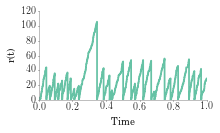

In [102]:
rank_count = rank_of_src_in_df(df, 1)
plt.step(rank_count.index, rank_count.mean(1), where='post')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.tight_layout()
format_axes(plt.gca())
latexify(fig_width=3.16, largeFonts=True)

In [103]:
[time_in_top_k(df, src_id=x, K=10, sim_opts=sim_opts) for x in sorted(df.src_id.unique())]

[0.25177123510846161, 1.0]

In [104]:
poisson_loss = calc_loss_poisson(df, u_const=u_int_opt(df, sim_opts=sim_opts), src_id=1, sim_opts=sim_opts)

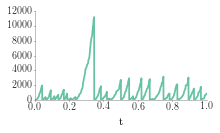

In [105]:
calc_loss_opt(df, sim_opts).plot()
plt.tight_layout()
format_axes(plt.gca())
latexify(columns=1, largeFonts=True)

## Synthetic experiments

In [106]:
%run -i options.py
%run -i utils.py
%run -i opt_model.py

In [18]:
%%time
sim_opts = SimOpts.std_poisson(world_seed=1 + 42, world_rate=10.0).update({ 'end_time': 100.0 })
tmp_kdd = worker_kdd((1, 567.0, 10, sim_opts, None, None))
tmp_poisson = worker_poisson((1, 567.0, sim_opts, None))
# tmp_oracle = worker_oracle((1, 567.0, 956, sim_opts, None))
# tmp_opt = worker_opt((1, sim_opts, None))

Done within 75 iterations!
Done within 696 iterations!
Done within 5306 iterations!
Done within 21661 iterations!
Done within 27250 iterations!
CPU times: user 15min 24s, sys: 323 ms, total: 15min 24s
Wall time: 15min 25s


In [5]:
%%time
sim_opts = SimOpts.std_piecewise_const(world_seed=1 + 42, 
                                       world_rates=np.arange(10) * 1.0,
                                       world_change_times=np.arange(10) * 10.0
                                      ).update({ 'end_time': 100.0 })
tmp_kdd = worker_kdd((1, 567.0, 9, sim_opts, None, None))
tmp_poisson = worker_poisson((1, 567.0, sim_opts, None))
# tmp_oracle = worker_oracle((1, 567.0, 956, sim_opts, None))
tmp_opt = worker_opt((1, sim_opts, None))

KeyboardInterrupt: 

In [22]:
tmp_kdd, tmp_poisson #, tmp_oracle, tmp_opt

({'avg_rank': 71.168424997482049,
  'avg_rank_1': 71.168424997482049,
  'avg_rank_10': 203.34746746143995,
  'avg_rank_20': 208.60555404195742,
  'avg_rank_3': 88.882515078230256,
  'avg_rank_5': 138.87975916174446,
  'avg_rank_k': 1,
  'kdd_opt_1': array([ 35.553,  33.872,  41.65 ,  58.911,  61.168,  76.685,  78.884,
          84.785,  95.492]),
  'kdd_opt_10': array([ 385.379,   22.145,   22.145,   22.147,   22.151,   22.296,
           22.42 ,   22.99 ,   25.327]),
  'kdd_opt_20': array([ 388.172,   22.353,   22.353,   22.353,   22.353,   22.353,
           22.353,   22.353,   22.353]),
  'kdd_opt_3': array([ 163.163,   16.859,   23.384,   39.962,   42.334,   60.521,
           63.277,   71.067,   86.432]),
  'kdd_opt_5': array([ 306.464,   10.498,   13.798,   24.602,   26.293,   39.132,
           41.16 ,   46.851,   58.203]),
  'kdd_opt_iters_1': 284,
  'kdd_opt_iters_10': 26815,
  'kdd_opt_iters_20': 27311,
  'kdd_opt_iters_3': 3988,
  'kdd_opt_iters_5': 15615,
  'r_2': 201.78194

In [56]:
%%time
sim_opts= SimOpts.std_hawkes(world_seed=1 + 42, world_lambda_0=1000.0, world_alpha=1.0, world_beta=10.0)
mgr = sim_opts.create_manager_for_wall()
mgr.run()

CPU times: user 747 ms, sys: 0 ns, total: 747 ms
Wall time: 745 ms


In [46]:
%%time
sim_opts = SimOpts.std_hawkes(world_seed=1 + 42, world_lambda_0=1000.0, world_alpha=1.0, world_beta=10.0)
worker_top_k_kdd((1, 3, 100.0, 10, sim_opts, None, None))

CPU times: user 5.59 s, sys: 0 ns, total: 5.59 s
Wall time: 5.59 s


In [3]:
%%time
import itertools as I
sim_opts = SimOpts(other_sources=[Poisson2(src_id=2, seed=seed, rate=1000.0)], 
                   end_time=100.0, 
                   src_id=1,
                   q_vec=q_vec,
                   s=s,
                   sink_ids=[1001],
                   edge_list=[(1, 1001), (2, 1001)])

with mp.Pool() as pool:
    N = 10
    K = 10
    seeds = range(0, N)
    seed_capacity = [None] * N
    opt_top_k_perf = [None] * N
    for idx, opt_dict in enumerate(pool.map(worker_top_k_opt,
                                            [(s, K, SimOpts.std_poisson(world_seed=s, world_rate=1000.0), None)
                                            for s in seeds])):
        seed_capacity[idx] = opt_dict['capacity']
        opt_top_k_perf[idx] = opt_dict['perf']
    
    poisson_top_k_perf = [None] * N
    for idx, poisson_dict in enumerate(pool.map(worker_top_k_poisson,
                                                [(s, K, seed_capacity[idx], 
                                                  SimOpts.std_poisson(world_seed=s, world_rate=1000.0), None)
                                                 for idx, s in enumerate(seeds)])):
        poisson_top_k_perf[idx] = poisson_dict['perf']

NameError: name 'seed' is not defined

# Inference new

In [205]:
%run -i opt_model.py

In [206]:
%run -i utils.py

In [207]:
Ks

[1, 5]

In [208]:
poisson_inf_opts._get_dict()

{'N': 10,
 'T': 100.0,
 'log_s_high': 7.0,
 'log_s_low': -4.0,
 'num_segments': 10,
 'sim_opts_gen': <function __main__.<lambda>>,
 'world_alpha': 1.0,
 'world_beta': 10.0,
 'world_rate': 10.0}

In [288]:
%run -i utils.py

In [289]:
%%time
poisson_res_2_kdd = run_inference_queue_kdd(opts=poisson_inf_opts)

*** 2016-05-19 19:16:55.153966 Checkpoint: active_procs = 90, procs = [('Opt', 0), ('kdd', 90)]
*** 2016-05-19 19:16:56.116184 Checkpoint: active_procs = 80, procs = [('Opt', 0), ('kdd', 80)]
*** 2016-05-19 19:16:56.920064 Checkpoint: active_procs = 70, procs = [('Opt', 0), ('kdd', 70)]
*** 2016-05-19 19:16:57.276536 Checkpoint: active_procs = 60, procs = [('Opt', 0), ('kdd', 60)]
*** 2016-05-19 19:16:57.724872 Checkpoint: active_procs = 50, procs = [('Opt', 0), ('kdd', 50)]
*** 2016-05-19 19:16:58.610404 Checkpoint: active_procs = 40, procs = [('Opt', 0), ('kdd', 40)]
*** 2016-05-19 19:16:59.920095 Checkpoint: active_procs = 30, procs = [('Opt', 0), ('kdd', 30)]
*** 2016-05-19 19:17:11.170155 Checkpoint: active_procs = 20, procs = [('Opt', 0), ('kdd', 20)]
*** 2016-05-19 19:17:25.740024 Checkpoint: active_procs = 10, procs = [('Opt', 0), ('kdd', 10)]
*** 2016-05-19 19:17:27.053146 Checkpoint: active_procs = 0, procs = [('Opt', 0), ('kdd', 0)]
Cleaning up 47 processes
CPU times: user 1

utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an erro

In [290]:
poisson_res_2_kdd.df

(200, 9)

In [292]:
%%time
hawkes_res_2_kdd = run_inference_queue_kdd(opts=hawkes_inf_opts)

*** 2016-05-19 19:19:26.627315 Checkpoint: active_procs = 90, procs = [('Opt', 0), ('kdd', 90)]
*** 2016-05-19 19:19:27.400135 Checkpoint: active_procs = 80, procs = [('Opt', 0), ('kdd', 80)]
*** 2016-05-19 19:19:29.398553 Checkpoint: active_procs = 70, procs = [('Opt', 0), ('kdd', 70)]
*** 2016-05-19 19:19:30.396026 Checkpoint: active_procs = 60, procs = [('Opt', 0), ('kdd', 60)]
*** 2016-05-19 19:19:32.376623 Checkpoint: active_procs = 50, procs = [('Opt', 0), ('kdd', 50)]
*** 2016-05-19 19:19:34.918548 Checkpoint: active_procs = 40, procs = [('Opt', 0), ('kdd', 40)]
*** 2016-05-19 19:19:36.621382 Checkpoint: active_procs = 30, procs = [('Opt', 0), ('kdd', 30)]
*** 2016-05-19 19:19:42.234012 Checkpoint: active_procs = 20, procs = [('Opt', 0), ('kdd', 20)]
*** 2016-05-19 19:19:54.915135 Checkpoint: active_procs = 10, procs = [('Opt', 0), ('kdd', 10)]
*** 2016-05-19 19:19:56.862946 Checkpoint: active_procs = 0, procs = [('Opt', 0), ('kdd', 0)]
Cleaning up 47 processes
CPU times: user 9

utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)
utils.py:693: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an erro

In [293]:
poisson_res_2_old = poisson_res_2

In [306]:
poisson_res_2 = poisson_res_2_old

In [307]:
poisson_res_2 = poisson_res_2.set('df', pd.concat([poisson_res_2.df, poisson_res_2_kdd.df[poisson_res_2_kdd.df.type == 'kdd']]))

In [301]:
hawkes_res_2_old = hawkes_res_2

In [311]:
hawkes_res_2 = hawkes_res_2_old

In [312]:
hawkes_res_2 = hawkes_res_2.set('df', pd.concat([hawkes_res_2.df, hawkes_res_2_kdd.df[hawkes_res_2_kdd.df.type == 'kdd']]))

In [314]:
hawkes_res_2.df.shape

(400, 9)

In [ ]:
%%time
poisson_res_2 = run_inference_queue(opts=poisson_inf_opts)

*** 2016-05-19 00:13:10.395255 Checkpoint: active_procs = 100, procs = [('Opt', 98), ('Oracle', 1), ('Poisson', 1)]
*** 2016-05-19 00:13:10.459243 Checkpoint: active_procs = 110, procs = [('Opt', 88), ('Oracle', 11), ('Poisson', 11)]
*** 2016-05-19 00:13:10.470540 Checkpoint: active_procs = 120, procs = [('Opt', 78), ('Oracle', 21), ('Poisson', 21)]
*** 2016-05-19 00:13:10.491588 Checkpoint: active_procs = 130, procs = [('Opt', 68), ('Oracle', 31), ('Poisson', 31)]
*** 2016-05-19 00:13:10.500869 Checkpoint: active_procs = 140, procs = [('Opt', 58), ('Oracle', 41), ('Poisson', 41)]
*** 2016-05-19 00:13:10.539984 Checkpoint: active_procs = 150, procs = [('Opt', 48), ('Oracle', 51), ('Poisson', 51)]
*** 2016-05-19 00:13:10.578868 Checkpoint: active_procs = 160, procs = [('Opt', 38), ('Oracle', 61), ('Poisson', 61)]
*** 2016-05-19 00:13:10.645803 Checkpoint: active_procs = 170, procs = [('Opt', 28), ('Oracle', 71), ('Poisson', 71)]
*** 2016-05-19 00:13:10.734330 Checkpoint: active_procs = 

In [ ]:
perf_opts.Ks

In [ ]:
poisson_res_2.raw_results[0]

In [ ]:
%%time
hawkes_res_2 = run_inference_queue(opts=hawkes_inf_opts)

In [ ]:
%run -i utils.py
%run -i opt_model.py

In [ ]:
%%time
piecewise_res_2 = run_inference_queue(opts=piecewise_inf_opts)

In [ ]:
worker_kdd((9, (opt_mgr.state.get_dataframe().src_id == sim_opts.src_id).sum() * 1.0, 10, sim_opts, None, None))

# Inference old method

In [ ]:
%%time
poisson_res = run_inference(opts=poisson_inf_opts)

In [ ]:
%%time
hawkes_res = run_inference(opts=hawkes_inf_opts)

In [ ]:
%%time
piecewise_res = run_inference(opts=piecewise_inf_opts)

In [42]:
import pickle
import seqfile

In [217]:
def strip_sim_opts_from_raw_results(d):
    def rm_sim_opts(d_in):
        return {k: v for k, v in d_in.items() if k != 'sim_opts'}
    
    return {k: (v if k != 'raw_results' else [rm_sim_opts(x) for x in v]) 
            for k, v in poisson_res._get_dict().items()}
    

In [60]:
tmp = strip_sim_opts_from_raw_results(poisson_res._get_dict())

In [61]:
tmp.keys()

dict_keys(['capacities', 'raw_results', 'df'])

In [62]:
tmp['raw_results'][1].keys()

dict_keys(['world_events', 'capacity', 'seed', 'r_2', 'top_3', 'avg_rank', 'type', 's', 'num_events', 'top_5', 'top_1', 'top_20', 'top_10'])

In [218]:
import seqfile
with open(seqfile.findNextFile(prefix='synthetic-', suffix='.pickle'), 'wb') as pickle_file:
    pickle.dump({'poisson': strip_sim_opts_from_raw_results(poisson_res._get_dict()), 
                 'hawkes': strip_sim_opts_from_raw_results(hawkes_res._get_dict()), 
                 'piecewise': strip_sim_opts_from_raw_results(piecewise_res._get_dict())}, pickle_file)
    print('Wrote {}'.format(pickle_file.name))

Wrote ./synthetic-5.pickle


In [219]:
with open(seqfile.findNextFile(prefix='synthetic-', suffix='.pickle'), 'wb') as pickle_file:
    pickle.dump({'poisson': strip_sim_opts_from_raw_results(poisson_res._get_dict()), 
                 'hawkes': strip_sim_opts_from_raw_results(hawkes_res._get_dict()), 
                 'piecewise': strip_sim_opts_from_raw_results(piecewise_res._get_dict())}, pickle_file)
    print('Wrote {}'.format(pickle_file.name))

Wrote ./synthetic-6.pickle


In [65]:
defined = False
try:
    poisson_res, hawkes_res, piecewise_res
    defined = True
except NameError:
    pass

if defined:
     confirmation = input('Some variables are already defined. Are you sure you want to clobber them? [Y/n]')
    
if confirmation.lower().startswith('y'):
    with open('synthetic-wrong.pickle', 'rb') as pickle_file:
        reloaded = pickle.load(pickle_file)

    poisson_res = Options(**reloaded['poisson'])
    hawkes_res = Options(**reloaded['hawkes'])
    piecewise_res = Options(**reloaded['piecewise'])
else:
    print('Cloberring averted.')

Some variables are already defined. Are you sure you want to clobber them? [Y/n]n
Cloberring averted.


In [66]:
tmp = [x for x in poisson_res.raw_results if x['type'] == 'Opt']
tmp2 = pd.DataFrame.from_records(tmp)
np.sum(tmp2.capacity < tmp2.num_events) / tmp2.shape[0]

0.0

In [134]:
np.sum(tmp2.capacity), np.sum(tmp2.num_events)

(31781.458986215268, 31989)

In [45]:
tmp2.sort_values('capacity').head(10)

,capacity,num_events,perf,seed,sim_opts,type
250,11.386027,15,0.057064,3,<__main__.SimOpts object at 0x7fdd4ed00c18>,Opt
156,12.239445,16,0.046731,7,<__main__.SimOpts object at 0x7fdd53b8dda0>,Opt
151,12.555923,15,0.039193,3,<__main__.SimOpts object at 0x7fdd53b714e0>,Opt
254,12.558445,16,0.057302,7,<__main__.SimOpts object at 0x7fdd4ed24ba8>,Opt
248,12.975326,16,0.040138,1,<__main__.SimOpts object at 0x7fdd4ed00518>,Opt
257,13.013955,16,0.047825,8,<__main__.SimOpts object at 0x7fdd4ecc9668>,Opt
29,13.038352,15,0.054903,2,<__main__.SimOpts object at 0x7fdd56288358>,Opt
57,13.038352,15,0.054903,2,<__main__.SimOpts object at 0x7fdd540e2630>,Opt
150,13.038352,15,0.054903,2,<__main__.SimOpts object at 0x7fdd53bccda0>,Opt
158,13.122530,17,0.052711,8,<__main__.SimOpts object at 0x7fdd53b2b828>,Opt


In [88]:
tmp = poisson_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [96]:
tmp = hawkes_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [100]:
tmp = piecewise_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [101]:
tmp['capacities'] = [np.mean([y for x, y in piecewise_res.capacities[s]]) for s in tmp.index]

In [102]:
tmp['Opt/Oracle'] = tmp['Opt'] / tmp['Oracle']

In [95]:
poisson_res.raw_results[0]

{'avg_rank': 0.9964988963059922,
 'broadcaster_events': 999,
 'capacity': 999.0,
 'num_events': 999,
 'r_2': 1.0001418442513226,
 's': 9.9999999999999995e-07,
 'seed': 0,
 'sim_opts': <__main__.SimOpts at 0x7fc808a01198>,
 'top_1': 99.005322577666675,
 'top_10': 100.0,
 'top_20': 100.0,
 'top_3': 100.0,
 'top_5': 100.0,
 'type': 'Opt',
 'world_events': 1004}

In [67]:
piecewise_res.capacities[piecewise_res.df.s[0]]

[(3, 730.0),
 (0, 747.0),
 (7, 746.0),
 (4, 773.0),
 (1, 711.0),
 (8, 737.0),
 (5, 771.0),
 (2, 792.0),
 (9, 770.0),
 (6, 720.0)]

In [94]:
tmp = [x for x in raw_results if x['type'] == 'kdd']

In [123]:
idx = len(tmp) - 1
tmp[idx]

{'kdd_opt': array([  64.382,   78.114,  101.586,  114.336,   76.14 ,   99.839,
          85.668,  127.037,   64.294,   94.166]),
 'perf': 0.84974391184022691,
 's': 1e-08,
 'seed': 9,
 'type': 'kdd'}

In [124]:
np.sum(tmp[idx]['kdd_opt'])

905.5634469866709

In [125]:
sim_opts = SimOpts.std_poisson(world_seed=tmp[idx]['seed'], world_rate=world_rate)
mgr = sim_opts.create_manager_for_piecewise_const(tmp[idx]['seed'], np.arange(num_segments) * (T / num_segments), 
                                                  tmp[idx]['kdd_opt'] / (T / num_segments))
mgr.run()

In [126]:
df = mgr.state.get_dataframe()

In [127]:
df[df.src_id == 1].shape

(933, 5)

In [60]:
world_changing_rates

array([ 6872.701,  9753.572,  8659.97 ,  7993.292,  5780.093,  5779.973,
        5290.418,  9330.881,  8005.575,  8540.363])

In [170]:
%run -i utils.py
%run -i opt_model.py

In [78]:
%%time
sim_opts = SimOpts.std_piecewise_const(world_seed=1, 
                                       world_change_times=world_change_times,
                                       world_rates=world_changing_rates  / 10.0)

*** 2016-05-06 23:17:36.775776 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 16 
*** 2016-05-06 23:17:36.822124 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 19 
*** 2016-05-06 23:17:36.865436 Checkpoint: s_lo = 0.125, s_hi = 0.25, num_events = 23 
*** 2016-05-06 23:17:36.908808 Checkpoint: s_lo = 0.0625, s_hi = 0.125, num_events = 29 
*** 2016-05-06 23:17:36.952059 Checkpoint: s_lo = 0.03125, s_hi = 0.0625, num_events = 38 
*** 2016-05-06 23:17:36.995332 Checkpoint: s_lo = 0.015625, s_hi = 0.03125, num_events = 44 
*** 2016-05-06 23:17:37.038704 Checkpoint: s_lo = 0.0078125, s_hi = 0.015625, num_events = 51 
*** 2016-05-06 23:17:37.038984 Checkpoint: s_lo = 0.0078125, s_hi = 0.015625
*** 2016-05-06 23:17:37.082146 Checkpoint: s_try = 0.01171875, events = 47, cost = 0.34094464338074343
*** 2016-05-06 23:17:37.125737 Checkpoint: s_try = 0.009765625, events = 51, cost = 0.29237130465832506
*** 2016-05-06 23:17:37.169080 Checkpoint: s_try = 0.0107421875, events = 48, cost = 0.31704

In [172]:
opt_oracle=find_opt_oracle(50.0, sim_opts, verbose=True)

*** 2016-05-07 01:47:38.712765 Checkpoint: s_lo = 1.0, s_hi = 2.0, num_events = 59 
*** 2016-05-07 01:47:43.295365 Checkpoint: s_lo = 2.0, s_hi = 4.0, num_events = 50 
*** 2016-05-07 01:47:47.877662 Checkpoint: s_lo = 4.0, s_hi = 8.0, num_events = 38 
*** 2016-05-07 01:47:47.877921 Checkpoint: s_lo = 4.0, s_hi = 8.0
*** 2016-05-07 01:47:52.475038 Checkpoint: s_try = 6.0, events = 43, cost = 190.24351658547735
*** 2016-05-07 01:47:57.100385 Checkpoint: s_try = 5.0, events = 44, cost = 167.86559770034106
*** 2016-05-07 01:48:01.686475 Checkpoint: s_try = 4.5, events = 47, cost = 156.45216699162305
*** 2016-05-07 01:48:06.268635 Checkpoint: s_try = 4.25, events = 48, cost = 150.4490239466958
*** 2016-05-07 01:48:10.907890 Checkpoint: s_try = 4.125, events = 49, cost = 147.34170023154488
*** 2016-05-07 01:48:15.692948 Checkpoint: s_try = 4.0625, events = 50, cost = 145.75934253252828


In [159]:
find_opt_oracle_time_top_k(50.0, sim_opts=sim_opts, K=3, tol=1e-2, verbose=True)

*** 2016-05-07 01:33:01.357070 Checkpoint: s_lo = 1.0, s_hi = 2.0, num_events = 59 
*** 2016-05-07 01:33:06.003020 Checkpoint: s_lo = 2.0, s_hi = 4.0, num_events = 50 
*** 2016-05-07 01:33:10.599267 Checkpoint: s_lo = 4.0, s_hi = 8.0, num_events = 38 
*** 2016-05-07 01:33:10.599564 Checkpoint: s_lo = 4.0, s_hi = 8.0
*** 2016-05-07 01:33:15.257199 Checkpoint: s_try = 6.0, events = 43, cost = 190.24351658547735
*** 2016-05-07 01:33:19.922371 Checkpoint: s_try = 5.0, events = 44, cost = 167.86559770034106
*** 2016-05-07 01:33:24.563932 Checkpoint: s_try = 4.5, events = 47, cost = 156.45216699162305
*** 2016-05-07 01:33:29.190108 Checkpoint: s_try = 4.25, events = 48, cost = 150.4490239466958
*** 2016-05-07 01:33:33.795787 Checkpoint: s_try = 4.125, events = 49, cost = 147.34170023154488
*** 2016-05-07 01:33:38.633058 Checkpoint: s_try = 4.0625, events = 50, cost = 145.75934253252828


0.18739408117276624

In [193]:
oracle_df = opt_oracle['df']
rb_mgr = sim_opts.create_manager_with_times(oracle_df.t[oracle_df.events == 1] + 1e-10)
rb_mgr.run()
df = rb_mgr.state.get_dataframe()
time_in_top_k(rb_mgr.state.get_dataframe(), K=3, sim_opts=sim_opts) 

0.24397405812513501

In [197]:
oracle_rank_calc = rank_of_src_in_df(df=df, src_id=1)

In [166]:
(df.src_id == 1).sum()

50

In [18]:
%run -i opt_model.py

In [39]:
%%time
s_opt = find_opt_oracle_s(100, sim_opt_gen(0).update({ 'end_time': 1.0 }), verbose=True)

*** 2016-05-06 00:18:23.087473 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 94 
*** 2016-05-06 00:18:28.610656 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 118 
*** 2016-05-06 00:18:28.611289 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-06 00:18:34.356899 Checkpoint: s_try = 0.375, events = 104, cost = 28.115635566719792
CPU times: user 23.5 s, sys: 43.3 ms, total: 23.5 s
Wall time: 23.5 s


In [164]:
%%time
oracle_df = get_oracle_df(sim_opt_gen(0).update({'end_time': 1.0, 's': s_opt}))

CPU times: user 4.97 s, sys: 0 ns, total: 4.97 s
Wall time: 4.97 s


In [173]:
find_opt_oracle_time_top_k(100, 3, lambda: sim_opt_gen(0).update({'s': s_opt, 'end_time': 1.0}), verbose=True)

*** 2016-05-04 22:40:15.523984 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 95 
*** 2016-05-04 22:40:19.970286 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 120 
*** 2016-05-04 22:40:19.970578 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-04 22:40:24.360491 Checkpoint: s_try = 0.375, events = 109, cost = 28.447623149728294


0.37156877786354015

In [129]:
%time
o, _ = (sim_opt_gen(0).update({ 's': 1e-3, 'end_time': 1.0 }))
o.events.sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.9 µs


582

In [130]:
%time
o, _ = worker_s(sim_opt_gen(0).update({ 's': 100, 'end_time': 1.0 }))
o.events.sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


17

In [133]:
%%time
sim_opts_generator = lambda : sim_opt_gen(0).update({ 'end_time': 1.0 })
s_try = find_ideal_s(100, sim_opts_generator)

*** 2016-05-04 20:05:22.158060 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_tweets = 95 
*** 2016-05-04 20:05:30.702477 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_tweets = 120 
*** 2016-05-04 20:05:30.702862 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-04 20:05:39.416810 Checkpoint: s_try = 0.375, events = 109, cost = 28.447623149728294
CPU times: user 34.8 s, sys: 13.3 ms, total: 34.8 s
Wall time: 34.9 s


In [19]:
%%time
sim_opts = sim_opt_gen(0)
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
oracle_df = oracle_ranking(df=wall_mgr.state.get_dataframe(), 
                           sim_opts=sim_opt_gen(1))

KeyboardInterrupt: 

In [19]:
%%time
sim_opts = sim_opt_gen(0)
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
oracle_df = oracle_ranking(df=wall_mgr.state.get_dataframe(), 
                           sim_opts=sim_opt_gen(1))

KeyboardInterrupt: 

In [334]:
@optioned(option_arg='opts')
def rank_plot(res, field, file_name, title=None, with_std=True, save=False, log_y=True, legend=False, fig_width=None):
    vals = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.mean)
    std  = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.std)
    
    if title is None:
        if field == 'avg_rank':
            title = 'Avg. rank'
        elif field == 'r_2':
            title = r'$\int r^2$dt'
        else:
            title = 'Unknown axis'
            
    if fig_width is None:
        fig_width = 1.75
        
    latexify(fig_width=fig_width, largeFonts=False)
    c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)

    X = [np.mean(res.capacities[s]) for s in vals.index]
    plt.errorbar(X, vals.Opt, fmt='s-', yerr=std.Opt.values, label='Optimal',  color=c1, markersize=3, linewidth=0.75)
    # plt.errorbar(X, vals.Poisson, fmt='o-', yerr=std.Poisson.values, label='Poisson', color=c2, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.Oracle, fmt='d-', yerr=std.Oracle.values, label='Oracle', color=c3, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.kdd, fmt='^-', yerr=std.kdd.values, label='Karimi', color=c4, markersize=3, linewidth=0.75)
    
    plt.xscale('log')
    
    if log_y:
        plt.yscale('log')
        plt.yticks([10 ** i for i in [0, 2, 4]])
    
    if legend:
        plt.legend(loc="upper right")
        
    # plt.ylabel(title)
    plt.xlabel(r'Budget')
    # plt.ylim(None, 105)
    plt.xlim(4.5, None)
    plt.tight_layout()
    format_axes(plt.gca())
    
    if save:
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
        
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt.pdf')
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt-kdd.pdf')

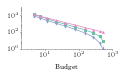

In [318]:
rank_plot(hawkes_res_2, 'avg_rank', None, log_y=True)

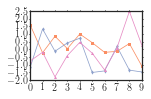

In [439]:
c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)
fig = plt.figure()
figlegend = plt.figure(figsize=(4 * 2.0, 0.25))
ax = fig.add_subplot(111)
lines = [
    ax.plot(range(10), np.random.randn(10), 's-', color=c2, markersize=3, label='RedQueen', linewidth=0.75)[0], 
    ax.plot(range(10), np.random.randn(10), 'd-', color=c3, markersize=3, label='Oracle', linewidth=0.75)[0],
    ax.plot(range(10), np.random.randn(10), '^-', color=c4, markersize=3, label='Karimi', linewidth=0.75)[0]
]
figlegend.legend(tuple(lines), ('RedQueen', 'Oracle', 'Karimi'), 'center', ncol=3)
figlegend.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/legend.pdf', bbox_inches='tight', pad_inches=0)

In [259]:
figlegend.legend?

In [270]:
figlegend.savefig('test.pdf')

In [22]:
hawkes_res.df.pivot_table(index='s', columns='type', values='r_2').index

Float64Index([1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], dtype='float64', name='s')

In [168]:
hawkes_res_higher_beta.df.pivot_table(index='s', columns='type', values='r_2', aggfunc=np.std)

type,Opt,Oracle,Poisson,kdd
s,,,,
1.000000e-08,0.004255,0.002257,0.377543,0.228007
1.000000e-07,0.013699,0.006435,0.708564,0.571351
1.000000e-06,0.058041,0.013762,1.468919,1.378015
1.000000e-05,0.229522,0.074677,4.076188,4.230126
1.000000e-04,0.866249,0.287207,9.320475,16.104886
1.000000e-03,3.766542,0.898753,25.476946,281.915090
1.000000e-02,16.224040,4.240223,87.953591,1259.529470
1.000000e-01,55.644573,20.417019,232.210492,2758.889224
1.000000e+00,218.081889,93.121546,1806.676547,10281.882413


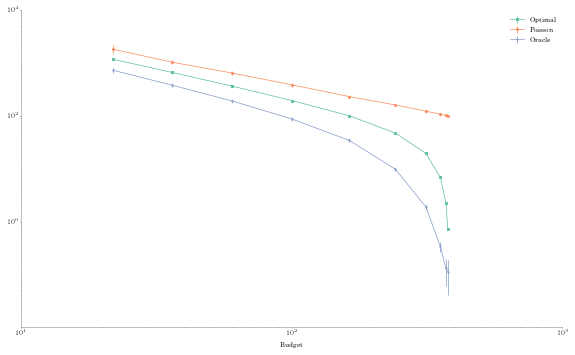

In [222]:
rank_plot(piecewise_res, 'avg_rank', None, legend=True, fig_width=8)

In [335]:
@optioned(option_arg='opts')
def top_k_plot(res, field, file_name, K=None, with_std=True, save=False, legend=False, fig_width=None, largeFonts=False):
    vals = res.df.pivot_table(index='s', columns='type', values=field, aggfunc='mean')
    std  = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.std)
    
    if K is None:
        assert field.startswith('top_')
        K = int(field[len('top_'):])

    if fig_width is None:
        fig_width = 1.75
        
    latexify(fig_width=fig_width, largeFonts=largeFonts)
    c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)

    X = [np.mean(res.capacities[s]) for s in vals.index]
    plt.errorbar(X, vals.Opt, fmt='s-', yerr=std.Opt.values, label='Optimal',  color=c1, markersize=3, linewidth=0.75)
    # plt.errorbar(X, vals.Poisson, fmt='o-', yerr=std.Poisson.values, label='Poisson', color=c2, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.Oracle, fmt='d-', yerr=std.Oracle.values, label='Oracle', color=c3, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.kdd, fmt='^-', yerr=std.kdd.values, label='Karimi', color=c4, markersize=3, linewidth=0.75)
    plt.xscale('log')
    if legend:
        plt.legend(loc="upper left")
    # plt.ylabel(r'$\int {{I}}(r(t) < {})dt$'.format(K))
    plt.xlabel(r'Budget')
    plt.ylim(-5, 105)
    plt.yticks([0, 50, 100])
    plt.xlim(4.5, None)
    plt.tight_layout()
    format_axes(plt.gca())
    if save:
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt.pdf')
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt-kdd.pdf')

In [183]:
piecewise_res.df.pivot_table(index='s', columns='type', values='top_1')

type,Opt,Oracle,Poisson
s,,,
0.000001,99.265603,99.887749,49.569384
0.000010,97.735429,99.869711,49.208997
0.000100,93.345349,99.660187,47.966030
0.001000,82.502168,98.137780,44.832798
0.010000,63.741640,90.497193,38.301633
0.100000,42.604444,69.574702,29.793909
1.000000,26.399126,45.733009,20.522375
10.000000,15.394732,29.057503,13.122382
100.000000,8.592110,17.542691,8.255395


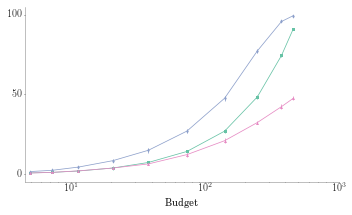

In [333]:
top_k_plot(poisson_res_2, 'top_1', '/tmp/test.pdf', save=False, fig_width=5, largeFonts=True)

In [188]:
poisson_res_2.df.columns

Index(['avg_rank', 'num_events', 'r_2', 's', 'seed', 'top_1', 'type',
       'world_events'],
      dtype='object')

In [250]:
tmp = poisson_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3775.626447,271.450000,930276.062968,1063771.421300,4.500000,16.792321,45.866765,998.400000
std,6877.641685,318.522294,3746813.663833,2999066.878561,2.886751,17.185526,36.256616,24.631424
min,101.417892,0.000000,286.276565,0.000100,0.000000,0.000000,0.525209,956.000000
25%,205.294872,18.750000,1026.565139,0.027826,2.000000,1.726655,9.158226,980.000000
50%,937.210705,102.000000,17952.364853,68.448802,4.500000,8.554189,38.553385,993.500000
75%,4467.226670,494.750000,355991.808174,35938.136638,7.000000,32.230900,85.744226,1022.000000
max,51602.111467,963.000000,34894547.293472,10000000.000000,9.000000,49.635027,97.436874,1035.000000


In [251]:
tmp = hawkes_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4620.816542,301.930000,1435908.914914,1063771.421300,4.500000,16.515543,44.783209,1155.500000
std,8514.776225,360.750124,5029173.581471,2999066.878561,2.886751,17.136917,36.462044,33.881105
min,94.909487,0.000000,281.466563,0.000100,0.000000,0.000000,0.138730,1113.000000
25%,217.732407,20.500000,1139.069265,0.027826,2.000000,1.706495,9.025254,1126.000000
50%,1071.553104,111.500000,23536.617241,68.448802,4.500000,8.259371,36.931077,1147.000000
75%,4980.140291,529.500000,416858.523927,35938.136638,7.000000,30.852401,85.071333,1198.000000
max,56634.343917,1087.000000,42792074.660449,10000000.000000,9.000000,51.374306,97.641337,1207.000000


In [253]:
tmp = piecewise_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2999.325583,220.010000,565300.529805,1063771.421300,4.500000,18.048286,48.686186,754.700000
std,5323.113679,249.077023,2132068.274656,2999066.878561,2.886751,17.429374,35.935099,25.085913
min,93.517316,0.000000,245.415447,0.000100,0.000000,0.000000,0.565336,715.000000
25%,184.210533,18.000000,865.050901,0.027826,2.000000,2.726000,12.729771,736.000000
50%,763.677975,93.500000,13713.628282,68.448802,4.500000,11.058082,45.657781,749.000000
75%,3559.701735,412.500000,210573.253905,35938.136638,7.000000,34.647645,88.574192,776.000000
max,39128.203550,743.000000,19743325.457668,10000000.000000,9.000000,50.042244,98.029689,799.000000


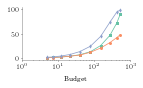

In [249]:
top_k_plot(hawkes_res_2, 'top_1', None)

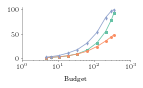

In [252]:
top_k_plot(piecewise_res_2, 'top_1', '/tmp/test.pdf', save=False)

## Plots

In [ ]:
import os
# base = '/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/'

In [ ]:
poisson_res.raw_results[0]

In [336]:
%%time
plot_base = '/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/'
for name, res in [('poisson', poisson_res_2), ('hawkes', hawkes_res_2)]: # , ('piecewise', piecewise_res_2)]:
    file_name = os.path.join(plot_base, 'avg-rank-{}-wall.pdf'.format(name))
    rank_plot(res, 'avg_rank', file_name, save=True)
    plt.close()
    
    file_name = os.path.join(plot_base, 'r2-{}-wall.pdf'.format(name))
    rank_plot(res, 'r_2', file_name, save=True)
    plt.close()
    
    file_name = os.path.join(plot_base, 'r2-{}-wall-linear.pdf'.format(name))
    rank_plot(res, 'r_2', file_name, save=True, log_y=False)
    plt.close()
    
    file_name = os.path.join(plot_base, 'avg-rank-{}-wall-linear.pdf'.format(name))
    rank_plot(res, 'avg_rank', file_name, save=True, log_y=False)
    plt.close()
    
    for k in [1]:
        file_name = os.path.join(plot_base, 'top-{}-{}-wall.pdf'.format(k, name))
        top_k_plot(res, 'top_{}'.format(k), file_name, save=True)
        plt.close()

CPU times: user 15.4 s, sys: 2.33 s, total: 17.7 s
Wall time: 26.9 s


In [146]:
simulation_opts.world_beta

2.0

In [79]:
%run -i opt_model.py

In [33]:
%%time
def plot_intensity(sim_opts, name):
    wall_mgr = sim_opts.create_manager_for_wall()
    wall_mgr.run()
    assert len(wall_mgr.sources) == 1
    broadcaster = wall_mgr.sources[0]
    X = np.linspace(start=0, stop=sim_opts.end_time, num=100)
    Y = [broadcaster.get_rate(t) for t in X]
    latexify(columns=1, largeFonts=False)
    plt.plot(X, Y)
    plt.xlabel('Time')
    plt.ylabel(r'$\lambda(t)$')
    plt.title('Sample intensity of {} wall'.format(name))
    plt.tight_layout()
    format_axes(plt.gca())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52.9 µs


CPU times: user 2.45 s, sys: 457 ms, total: 2.91 s
Wall time: 7.08 s


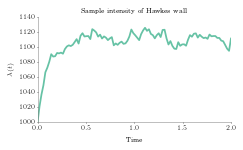

In [34]:
%%time
plot_intensity(SimOpts.std_hawkes(world_seed=1, 
                                  world_beta=10, 
                                  world_alpha=1, 
                                  world_lambda_0=1000).update({'end_time': 2}),
               'Hawkes')

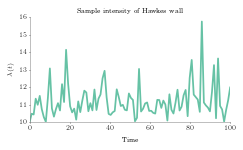

In [236]:
plot_intensity(hawkes_inf_opts.sim_opts_gen(5), 'Hawkes')
plt.savefig(os.path.join(plot_base, 'hawkes_intensity.pdf'), bbox_inches='tight', pad_inches=0)

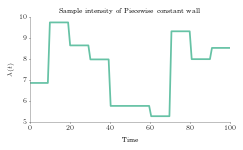

In [237]:
plot_intensity(piecewise_inf_opts.sim_opts_gen(5), 'Piecewise constant')
plt.savefig(os.path.join(plot_base, 'piecewise_const_intenstiy.pdf'),  bbox_inches='tight', pad_inches=0)

In [194]:
%run -i utils.py

In [195]:
sim_opts = SimOpts.std_hawkes(world_seed=101, world_lambda_0=0
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
df = wall_mgr.state.get_dataframe()

In [196]:
%time or_new, J_new = oracle_ranking_new(df=df, sim_opts=sim_opts)

CPU times: user 5.42 s, sys: 3.33 ms, total: 5.42 s
Wall time: 5.42 s


In [197]:
%time or_old, J_old = oracle_ranking(df=df, sim_opts=sim_opts)

CPU times: user 4.91 s, sys: 3.33 ms, total: 4.91 s
Wall time: 4.91 s


## Compare against Mohammed's method

In [47]:
import broadcast.data as Bdata
import broadcast.opt.optimizer as Bopt

In [127]:
reload(Bopt)

<module 'broadcast.opt.optimizer' from '/NL/stackexchange/work/prog/broadcast_ref/broadcast/opt/optimizer.py'>

In [162]:
world_rate = 1.0
num_segments = 10
K = 1
T = 1000.0

rs = np.random.RandomState(42)
low_high_ratio = 0.75
world_rates = rs.uniform(low=world_rate * (1 - low_high_ratio),
                         high=world_rate * (1 + low_high_ratio), 
                         size=num_segments)

# wall_mgr = (SimOpts.std_poisson(world_rate=world_rate, world_seed=0)
sim_opts = (SimOpts.std_piecewise_const(world_seed=1, world_rates=world_rates, 
                                        world_change_times=np.arange(num_segments) / num_segments * T)
            .update({ 'end_time': T }))
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()

wall_df = wall_mgr.state.get_dataframe()
wall_intensities = wall_df.groupby((wall_df.t.values / T * num_segments).astype(int)).size() / (T / num_segments)
# wall_intensities = np.asarray([1000] * num_segments)
# wall_intensities = world_rates

follower_wall_intensities = np.array([wall_intensities])
follower_conn_prob = np.array([[1.0] * num_segments])
follower_weights = np.array([1.0])

def _util(x):
    return Bopt.utils.weighted_top_k(x, follower_wall_intensities, follower_conn_prob, follower_weights, K)

def _util_grad(x):
    return Bopt.utils.weighted_top_k_grad(x, follower_wall_intensities, follower_conn_prob, follower_weights, K)

x0 = np.ones(num_segments)
budget = 100.0
upper_bounds = np.array([1e6] * num_segments)
threshold=0.005 # Relative tolerance for convergence

kdd_opt = Bopt.optimize(util=_util, 
                        util_grad=_util_grad, 
                        budget=budget, 
                        upper_bounds=upper_bounds, 
                        threshold=threshold, 
                        x0=x0, verbose=True)

Done within 5 iterations!


In [154]:
world_rates

array([ 0.812,  1.676,  1.348,  1.148,  0.484,  0.484,  0.337,  1.549,
        1.152,  1.312])

In [147]:
kdd_opt

array([ 53.055,   6.363,   6.315,   5.989,   3.975,   3.839,   2.812,
         6.408,   5.859,   5.384])

In [142]:
Bopt.utils.weighted_top_k(kdd_opt, follower_wall_intensities, follower_conn_prob, follower_weights, K)

9.0479951229125444

In [137]:
worker_kdd((0, 100.0, 10, sim_opts, world_rates, None))

{'avg_rank': 10491.437269802806,
 'avg_rank_1': 10491.437269802806,
 'avg_rank_10': 61242.581748687509,
 'avg_rank_20': 226590.96318318188,
 'avg_rank_3': 13302.994162979969,
 'avg_rank_5': 22690.897577060408,
 'avg_rank_k': 1,
 'kdd_opt_1': array([ 13.507,  11.172,  10.674,  10.245,   8.124,   8.024,   7.241,
         10.954,  10.151,   9.908]),
 'kdd_opt_10': array([ 87.022,   0.006,   2.713,   2.477,   1.292,   0.941,   0.945,
          2.587,   2.014,   0.004]),
 'kdd_opt_20': array([ 97.737,   0.007,   0.198,   0.394,   0.415,   0.416,   0.409,
          0.371,   0.049,   0.005]),
 'kdd_opt_3': array([ 36.915,   8.616,   8.249,   7.699,   5.296,   5.278,   4.345,
          8.673,   7.624,   7.307]),
 'kdd_opt_5': array([ 62.766,   4.773,   5.279,   4.714,   3.126,   3.145,   2.251,
          5.331,   4.932,   3.682]),
 'kdd_opt_iters_1': 5,
 'kdd_opt_iters_10': 400,
 'kdd_opt_iters_20': 480,
 'kdd_opt_iters_3': 89,
 'kdd_opt_iters_5': 234,
 'r_2': 232479.11339480593,
 'r_2_1': 232

In [155]:
wall_intensities

array([ 0.812,  1.676,  1.348,  1.148,  0.484,  0.484,  0.337,  1.549,
        1.152,  1.312])

In [150]:
wall_intensities

0    0.70
1    1.68
2    1.43
3    1.11
4    0.55
5    0.59
6    0.42
7    1.38
8    1.10
9    1.39
dtype: float64

In [120]:
kdd_opt

100.0

In [78]:
sum(kdd_opt)

100.0

In [79]:
sim_opts = SimOpts.std_piecewise_const(world_seed=0, world_change_times=np.arange(num_segments) * (T / num_segments), 
                                       world_rates=kdd_opt * 10)

In [80]:
wall_mgr = sim_opts.create_manager_for_wall()

In [81]:
wall_mgr.run()

In [82]:
df = wall_mgr.state.get_dataframe()

In [74]:
df.t.values * 10

array([ 5.218,  5.289,  5.68 ,  6.028,  6.668,  6.818,  7.742,  7.782,
        7.805,  7.917,  7.992,  8.7  ])

In [85]:
df.t.groupby((df.t.values * 10).astype(int)).size()

0     2
5    33
6     7
7    38
8    14
dtype: int64

In [161]:
np.sum(world_rates * (T / num_segments))

1030.2051039290122

In [163]:
np.sum(wall_intensities * (T / num_segments))

1035.0

In [ ]:
#pc_wall_mgr = SimOpts.std_piecewise_const(world_seed=1, world_change_times)

In [323]:
df = poisson_res_2.df

In [327]:
df.pivot_table(index='s', values='top_1', columns='type', aggfunc=np.mean)

type,Opt,Oracle,Poisson,kdd
s,,,,
0.000100,91.364467,99.530182,47.734702,47.548313
0.001668,74.431284,95.823468,42.211243,42.247671
0.027826,48.361404,77.298801,32.127741,32.245158
0.464159,26.834463,47.551197,20.918398,20.817688
7.742637,14.073225,26.895195,12.083601,12.077850
129.154967,7.127160,14.792741,6.289259,6.210012
2154.434690,3.614960,8.241672,3.605528,3.610374
35938.136638,1.749342,4.215994,1.675942,1.849785
599484.250319,0.874652,2.175858,0.831468,0.878096


In [326]:
df.pivot_table(index='s', values='top_1', columns='type', aggfunc=np.std)

type,Opt,Oracle,Poisson,kdd
s,,,,
0.000100,0.327185,0.114165,1.594643,1.262253
0.001668,0.735968,0.310643,1.473769,1.634483
0.027826,0.994214,1.228987,1.667879,1.215967
0.464159,1.055291,1.663420,1.262969,1.473501
7.742637,1.185131,1.439466,1.416186,1.258427
129.154967,0.656280,1.413249,0.762736,0.815361
2154.434690,0.981349,0.770348,0.568365,0.562886
35938.136638,0.695556,0.691490,0.439283,0.637002
599484.250319,0.342350,0.516736,0.480644,0.349610


## Find the q_vec which provides a certain capacity

In [134]:
%run -i opt_model.py

In [227]:
%%time
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        'other_sources': [Poisson(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })
# tmp = calc_q_capacity_iter(sim_opts)
tmp3_poisson_1 = calc_q_capacity_iter(sim_opts)

CPU times: user 110 ms, sys: 157 ms, total: 267 ms
Wall time: 2min 48s


In [228]:
tmp3_poisson_1.mean()

7967.1629870452907

In [229]:
%run -i opt_model.py

In [230]:
%%time
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        'other_sources': [Poisson2(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })
# tmp = calc_q_capacity_iter(sim_opts)
tmp3_poisson_2 = calc_q_capacity_iter(sim_opts)

CPU times: user 83.3 ms, sys: 113 ms, total: 197 ms
Wall time: 2min 7s


In [231]:
tmp3_poisson_2.mean()

7960.4575864000271

In [174]:
np.random.uniform(10)

1.4617278497435535

In [153]:
tmp2

0.99971767328613059

In [97]:
%%time
tmp2 = calc_q_capacity_iter(sim_opts, parallel=True)

CPU times: user 40 ms, sys: 367 ms, total: 407 ms
Wall time: 16.7 s


In [98]:
tmp2

array([ 2511.25097053,  2496.03117259,  2485.56253613,  2491.14835052,
        2498.94430075,  2519.40042709,  2505.5330253 ,  2495.03242928,
        2514.54890424,  2540.22786683])

In [99]:
tmp

array([ 2508.61413281,  2524.15419948,  2520.59906929,  2516.93533233,
        2552.68473306,  2484.32193195,  2501.59290153,  2490.1465022 ,
        2481.68386686,  2460.78773208])

In [102]:
tmp3.mean()

2504.1520401572761

In [103]:
tmp4 = calc_q_capacity_iter(sim_opts.update({ 's': 2.0 }), parallel=True)

In [104]:
tmp4.mean()

2110.2250458304434

In [145]:
%run -i utils.py

In [238]:
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        # 'other_sources': [Poisson2(src_id=2, seed=1, rate=10000.0)],
        'other_sources': [Poisson(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [148]:
%%time
s_opt = sweep_s(lambda: SimOpts.std_poisson(world_seed=1, world_rate=100.0), capacity_cap=100.0, verbose=True)

*** 2016-05-04 21:59:44.864163 Checkpoint: Initial capacity = 769.0321811055888
*** 2016-05-04 22:00:06.321337 Checkpoint: s_hi = 4096.0, s_lo = 2048.0
*** 2016-05-04 22:00:07.986757 Checkpoint: new_capacity = 106.16027670602416, s = 3072.0
*** 2016-05-04 22:00:09.666732 Checkpoint: new_capacity = 101.194622540465, s = 3584.0
*** 2016-05-04 22:00:11.336612 Checkpoint: new_capacity = 99.42532014279948, s = 3840.0
CPU times: user 210 ms, sys: 2.12 s, total: 2.33 s
Wall time: 28.5 s


In [149]:
s_opt

3840.0

In [239]:
%%time
# This is with Poisson: Took ~ 47min, 44s
s_opt = sweep_s(sim_opts, 50000.0, verbose=True)

*** 2016-05-02 00:12:20.257822 Checkpoint: Initial capacity = 7967.162987045291
*** 2016-05-02 00:44:22.309096 Checkpoint: s_hi = 0.0009765625, s_lo = 0.00048828125
*** 2016-05-02 00:46:56.892996 Checkpoint: new_capacity = 47736.13035565209, s = 0.000732421875
*** 2016-05-02 00:49:32.194914 Checkpoint: new_capacity = 49913.7414199194, s = 0.0006103515625
*** 2016-05-02 00:52:06.251847 Checkpoint: new_capacity = 51218.96161754592, s = 0.00054931640625
*** 2016-05-02 00:54:41.662719 Checkpoint: new_capacity = 50540.20193159806, s = 0.000579833984375
*** 2016-05-02 00:57:16.650763 Checkpoint: new_capacity = 50224.656253556066, s = 0.0005950927734375
CPU times: user 1.96 s, sys: 2.18 s, total: 4.14 s
Wall time: 47min 44s


In [233]:
%%time
# This was with Poisson2: Took ~ 35min, 24s
s_opt = sweep_s(sim_opts, 50000.0, verbose=True)

*** 2016-05-01 22:57:44.982005 Checkpoint: Initial capacity = 7960.457586400027
*** 2016-05-01 23:21:25.507846 Checkpoint: s_hi = 0.0009765625, s_lo = 0.00048828125
*** 2016-05-01 23:23:19.044300 Checkpoint: new_capacity = 47686.2063074488, s = 0.000732421875
*** 2016-05-01 23:25:12.821979 Checkpoint: new_capacity = 49871.05306762598, s = 0.0006103515625
*** 2016-05-01 23:27:08.958602 Checkpoint: new_capacity = 51169.0749459018, s = 0.00054931640625
*** 2016-05-01 23:29:03.197845 Checkpoint: new_capacity = 50501.14818392287, s = 0.000579833984375
*** 2016-05-01 23:30:57.014591 Checkpoint: new_capacity = 50177.111303157675, s = 0.0005950927734375
CPU times: user 1.58 s, sys: 2.26 s, total: 3.84 s
Wall time: 35min 24s


In [135]:
s_opt

2.5033950805664062e-06

In [132]:
s_opt

2.503393943698029e-06

In [201]:
def foo(T):
    rs = np.random.RandomState(42)
    t, dt = 0, 0
    n = 0
    while t + dt < T:
        t = t + dt
        n += 1
        dt = rs.exponential(1 / 1000.0)
    return t, n

def bar(T):
    rs = np.random.RandomState(42)
    n = rs.poisson(1000.0 * T)
    last_time = sorted(rs.uniform(high=T, size=n))[-1]
    return last_time, n


In [204]:
%timeit tmp1 = foo(1000)

1 loop, best of 3: 394 ms per loop


In [205]:
%timeit tmp2 = bar(1000)

1 loop, best of 3: 829 ms per loop


In [206]:
foo(1000), bar(1000)

((999.999833196945, 998932), (999.99831486095445, 999640))

In [245]:
%%time
import itertools as I

def worker(param):
    return np.sum(range(param * 10000000))

def foo(params):
    start, stop = params
    total = 0
    with mp.Pool() as pool:
        for s in pool.imap_unordered(worker, range(start, stop)):
            total += s
    return start, stop, total

# Does not work with 'Pool' class because "daemonic processes are not allowed to have children"
with mp.pool.ThreadPool() as pool:
    for start, stop, t in pool.imap_unordered(foo, zip(range(1, 10), range(100, 110))):
        print('start, stop, t = ', start, stop, t)
        
        
        

KeyboardInterrupt: 

## Extracting data for Mohammad

In [ ]:
num_segments = 10


## `s_init` heuristic

In [187]:
%run -i utils.py
%run -i opt_model.py

In [287]:
sim_opts = SimOpts.std_poisson(world_seed=1, world_rate=500)

In [288]:
sweep_s(lambda: sim_opts, 10, verbose=True, dynamic=True)

*** 2016-05-13 16:06:06.308683 Checkpoint: Initial capacity = 16.682815756349004, target capacity = 10
*** 2016-05-13 16:06:06.515228 Checkpoint: s = 2.0, capcity = 14.461590479654564
*** 2016-05-13 16:06:06.711105 Checkpoint: s = 4.0, capcity = 12.150333853228608
*** 2016-05-13 16:06:06.903814 Checkpoint: s = 8.0, capcity = 10.439782962439807
*** 2016-05-13 16:06:07.116908 Checkpoint: s = 16.0, capcity = 8.877513076274898
*** 2016-05-13 16:06:07.118326 Checkpoint: s_hi = 16.0, s_lo = 8.0
*** 2016-05-13 16:06:07.335871 Checkpoint: new_capacity = 9.554880390811231, s = 12.0


12.0

In [289]:
opt_mgr = sim_opts.update({ 's': 0.375 }).create_manager_with_opt(seed=1)
opt_mgr.run_dynamic()

In [290]:
opt_df = opt_mgr.state.get_dataframe()

In [291]:
opt_df[opt_df.src_id == sim_opts.src_id]

,event_id,sink_id,src_id,t,time_delta
0,100,1001,1,0.000000,0.000000
4,104,1001,1,0.002940,0.000070
32,132,1001,1,0.035653,0.001081
49,149,1001,1,0.077264,0.005290
60,160,1001,1,0.104315,0.001089
89,189,1001,1,0.155652,0.002980
105,205,1001,1,0.190397,0.001760
118,218,1001,1,0.214218,0.002258
137,237,1001,1,0.258508,0.001389
149,249,1001,1,0.275824,0.005616


In [292]:
wall_mgr = sim_opts.create_manager_for_wall()

In [293]:
wall_mgr.run_dynamic()

In [294]:
df = wall_mgr.state.get_dataframe()

In [295]:
r_t = rank_of_src_in_df(df, src_id=-1)

In [296]:
r_t.mean(1).iloc[-1]

495.0

In [297]:
df.shape

(495, 5)

In [298]:
(4 * (r_t.iloc[-1].mean() ** 2) * (sim_opts.end_time) ** 2) / (np.pi * np.pi * (10 + 1) ** 4) 

6.7826577479581491

In [60]:
hawkes_res.raw_results[-1
                      ]

{'avg_rank': 954.00681957353299,
 'broadcaster_events': 49,
 'num_events': 49,
 'r0_num_events': 49,
 'r_2': 13966.614080745609,
 's': 1000.0,
 'seed': 2,
 'sim_opts': <__main__.SimOpts at 0x7fc80895c358>,
 'top_1': 9.5668178314961985,
 'top_10': 52.303469506298647,
 'top_20': 90.47790271111036,
 'top_3': 20.567177074149754,
 'top_5': 30.583811352029109,
 'type': 'Oracle',
 'world_events': 1198}

In [58]:
[x['best_avg_k'] for x in hawkes_res.raw_results if x['type'] == 'KDD']

[]

# Run for user 52885404

In [338]:
base

'/NL/ghtorrent/work/opt-broadcast'

In [396]:
user_id = 20712572

In [397]:
# user_id = 35652801 s_opt = 3211150360.2065687
# s_opt = 155655.86986992834 for user_id = 52885404
user_raw = pickle.load(open(os.path.join(base, 'user-{}.pickle'.format(user_id)), 'rb'))

In [398]:
user_result = revert_to_sim_opts(user_raw)

In [399]:
user_raw.keys()

dict_keys(['user_event_times', 'scaled_period', 'num_user_events', 'sim_opts_dict', 'user_id'])

In [400]:
sim_opts = user_result['sim_opts']

In [401]:
user_raw.keys()

dict_keys(['user_event_times', 'scaled_period', 'num_user_events', 'sim_opts_dict', 'user_id'])

In [402]:
s_opt = sweep_s(sim_opts, user_raw['num_user_events'], verbose=True)

*** 2016-05-19 22:42:01.776325 Checkpoint: s_init = 23432203434.13262
*** 2016-05-19 22:43:03.950811 Checkpoint: Initial capacity = 28.884668978252176, target capacity = 30, s_init = 23432203434.13262
*** 2016-05-19 22:44:04.378174 Checkpoint: s = 11716101717.06631, capcity = 35.039623937742554
*** 2016-05-19 22:44:04.379748 Checkpoint: s_hi = 23432203434.13262, s_lo = 11716101717.06631
*** 2016-05-19 22:45:05.713041 Checkpoint: new_capacity = 31.287997490987454, s = 17574152575.599464
*** 2016-05-19 22:46:07.081210 Checkpoint: new_capacity = 29.89889301925127, s = 20503178004.866043


In [404]:
s_opt

20503178004.866043

In [405]:
opt_mgr = sim_opts.update({'s': s_opt}).create_manager_with_opt(seed=1)

In [406]:
%%time
opt_mgr.run_dynamic()

CPU times: user 31.1 s, sys: 1.79 s, total: 32.9 s
Wall time: 32.9 s


In [407]:
df_opt = opt_mgr.state.get_dataframe()

In [411]:
user_id, sim_opts.src_id

(20712572, 20712572)

In [409]:
real_mgr = sim_opts.update({'s': s_opt}).create_manager_with_times(event_times=user_result['user_event_times'])

In [410]:
%%time
real_mgr.run_dynamic()

CPU times: user 7.12 s, sys: 487 ms, total: 7.61 s
Wall time: 7.61 s


In [412]:
df_real = real_mgr.state.get_dataframe()

In [456]:
df_opt.event_id[df_opt.src_id == user_id].nunique()

32

In [455]:
df_real.event_id[df_real.src_id == user_id].nunique()

30

In [446]:
%run -i utils.py

In [447]:
%%time
# seed, capacity, num_segments, sim_opts, world_changing_rates, queue = params
kdd_perf = worker_kdd((1, user_result['num_user_events'] * 1.0, 60, sim_opts, None, None), verbose=True, Ks=[1])

Done within 9 iterations!
CPU times: user 21.8 s, sys: 2.23 s, total: 24 s
Wall time: 22.2 s


utils.py:696: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)


In [450]:
kdd_opt = kdd_perf['kdd_opt_1']

In [ ]:
kdd_mgr = sim_opts.create_manager_with_piecewise_const(seed=1, change_times = np.arange(60) / 60 * sim_opts. )

In [413]:
r_opt = rank_of_src_in_df(df_opt, user_id).mean(1)

In [414]:
r_real = rank_of_src_in_df(df_real, user_id).mean(1)

In [415]:
r_opt.shape

(606525,)

In [433]:
r_opt_sampled = pd.concat([r_opt[::200], r_opt[r_opt == 0]]).sort_index()

In [454]:
np.sum(r_opt == 0)

32

In [460]:
df_real.t[df_real.src_id == user_id].unique()

array([  251.906,   441.235,   455.121,   886.766,  1413.65 ,  1429.583,
        1700.907,  2508.858,  2509.022,  2706.411,  3645.805,  3648.546,
        3993.621,  4269.935,  4305.957,  4306.243,  4309.272,  4313.168,
        4325.23 ,  4662.313,  5412.7  ,  5415.166,  5790.916,  5791.006,
        5799.317,  5809.817,  6078.444,  6099.087,  6207.644,  6854.717])

In [469]:
r_real[(886.76 <= r_real.index) & (r_real.index <= 886.77)]

t
886.762619    775.066667
886.766353      0.016667
dtype: float64

In [462]:
r_real[(r_real == 0)].index

Float64Index([ 251.90598865, 441.235439068, 455.120594385, 1413.64994026,
              1700.90725806, 2508.85790024, 2509.02217742, 3645.80533154,
              3993.62119176,  4269.9354092, 4305.95691458, 4306.24253286,
              4309.27232676, 4313.16830944,  4325.2296147, 4662.31332139,
              5412.69974612, 5415.16577061, 5790.91621864, 5791.00582437,
              5799.31675627, 5809.81742832, 6207.64448925, 6854.71736858],
             dtype='float64', name='t')

In [434]:
r_real_sampled = pd.concat([r_real[::200], r_real[r_real == 0]]).sort_index()

In [440]:
c1, c2 = sns.mpl_palette('Set2', 2)

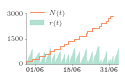

In [573]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_opt_sampled.index <= 5000.0
ymin, ymax = 0, 3000

plt.fill_between(60 * r_opt_sampled.index[one_month] / 10000, r_opt_sampled.values[one_month], color=c1,
                 label='$r(t)$',
                 alpha=0.5)

tweet_times = df_opt[(df_opt.src_id == user_id)].t.unique()
one_month_df = tweet_times < 5000.0
num_tweets = np.sum(one_month_df)

# plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.step(tweet_times[one_month_df] * 60 / 10000.0, np.arange(num_tweets) / num_tweets * ymax, 
         label='$N(t)$',
         color=c2, linewidth=1.0)

# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(0.5, 1.2), bbox_transform=plt.gca().transAxes)

plt.yticks([0, 1500, 3000])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
plt.tight_layout()
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'opt-data-counting.pdf'), bbox_inches='tight', pad_inches=0)

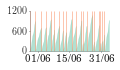

In [520]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_opt_sampled.index <= 5000.0
plt.fill_between(60 * r_opt_sampled.index[one_month] / 10000, r_opt_sampled.values[one_month], color=c1, alpha=0.5)

tweet_times = df_opt[(df_opt.src_id == user_id)].t.unique()
one_month_df = tweet_times < 5000.0
ymin, ymax = 0, 1200
plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.yticks([0, 600, 1200])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
plt.tight_layout()
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'opt-data-ranks.pdf'), bbox_inches='tight', pad_inches=0)

In [518]:
np.sum(one_month_df)

20

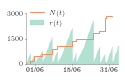

In [574]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_real_sampled.index <= 5000.0
plt.fill_between(60 * r_real_sampled.index[one_month] / 10000, r_real_sampled.values[one_month], 
                 label='$r(t)$', color=c1, alpha=0.5)

tweet_times = df_real[(df_real.src_id == user_id)].t.unique()
one_month_df = tweet_times < 5000.0
num_tweets = np.sum(one_month_df)
ymin, ymax = 0, 3000
# plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.step(tweet_times[one_month_df] * 60 / 10000.0, np.arange(num_tweets) / num_tweets * ymax, color=c2,
         label='$N(t)$',
         linewidth=1.0)

plt.yticks([0, 1500, 3000])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
# leg = plt.legend(loc="upper left")

# Get the bounding box of the original legend
# bb = leg.legendPatch.get_bbox().inverse_transformed(plt.gca().transAxes)
# leg.legendPatch.
plt.legend(bbox_to_anchor=(0.5, 1.2), bbox_transform=plt.gca().transAxes)

plt.tight_layout()
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'real-data-counting.pdf'), bbox_inches='tight', pad_inches=0)

In [562]:
bb

Bbox([[-0.16129032258064516, -0.16129032258064516], [-0.15104966717869944, -0.14472059407322177]])

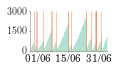

In [521]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_real_sampled.index / 10000, r_real_sampled.values)
one_month = r_real_sampled.index <= 5000.0
plt.fill_between(60 * r_real_sampled.index[one_month] / 10000, r_real_sampled.values[one_month], color=c1, alpha=0.5)

tweet_times = df_real[(df_real.src_id == sim_opts.src_id)].t.unique()
one_month_df = tweet_times < 5000.0
plt.vlines(tweet_times[one_month_df] * 60 / 10000.0, ymin=0, ymax=3000, color=c2, linewidth=0.5)
plt.tight_layout()
plt.yticks([0, 1500, 3000]) # , [0, r'$10^3$', r'$3\times 10^3$'])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'real-data-ranks.pdf'), bbox_inches='tight', pad_inches=0)

In [516]:
np.sum(one_month_df)

20

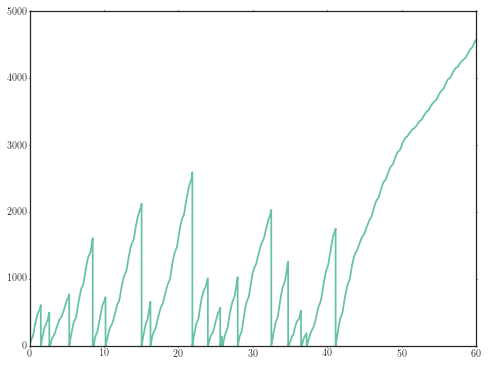

In [437]:
latexify(fig_width=2.0, largeFonts=True)
plt.figure(figsize=(8,6))
plt.plot(60 * r_real_sampled.index / 10000, r_real_sampled.values)

In [546]:
average_rank(df_opt, sim_opts=sim_opts) / sim_opts.end_time

422.95381261988513

In [547]:
average_rank(df_real, sim_opts=sim_opts) / sim_opts.end_time

1387.4009282506947